In [1]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gym
from torch.distributions import Normal, Categorical
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import csv

c:\Users\user\anaconda3\envs\test_RL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# 방법 1 : torch version
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

# 방법 1-2 : torch version 2
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0

True
GeForce GTX 1060 6GB


In [11]:
class ActorNet(nn.Module):
    def __init__(self, output_dim, hidden_dim=64):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(8, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)        
        self.mu_head = nn.Linear(hidden_dim, output_dim)

    def forward(self, s):
        x = F.relu(self.fc1(s.view(s.size(0), -1)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        u = F.tanh(self.mu_head(x))
        return u
        

In [12]:
class CriticNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(CriticNet, self).__init__()

        # State pathway
        self.fc_s = nn.Linear(state_dim, hidden_dim)
        self.fc_a = nn.Linear(action_dim, hidden_dim)

        # Combine state and action pathways
        self.fc_comb = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Critic head
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x_s = F.relu(self.fc_s(state))
        x_a = F.relu(self.fc_a(action))

        # Combine state and action pathways
        x_comb = F.relu(self.fc_comb(torch.cat([x_s, x_a], dim=1)))

        # Critic head
        q_value = self.critic_head(x_comb)

        return q_value

In [13]:
class Memory():
    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)

In [14]:
class Agent:
    max_grad_norm = 0.5

    def __init__(self, num_actions, state_dim):
        self.training_step = 0
        self.var = 1.
        # Initialize critic and actor networks with state_dim
        self.eval_cnet, self.target_cnet = CriticNet(state_dim, num_actions).float().to(device), CriticNet(state_dim, num_actions).float().to(device)
        self.eval_anet, self.target_anet = ActorNet(num_actions).float().to(device), ActorNet(num_actions).float().to(device)  # 수정: output_dim은 num_actions로 설정
        self.memory = Memory(2000)
        self.optimizer_c = optim.AdamW(self.eval_cnet.parameters(), lr=1e-4)
        self.optimizer_a = optim.AdamW(self.eval_anet.parameters(), lr=1e-4)

    def select_action(self, state):
        state = state.float().unsqueeze(0).to(device)
        
        logits = self.eval_anet(state)
        
        exploration_noise = torch.normal(0, 0.1, size=logits.size()).to(device)        

        logits_with_noise = logits + exploration_noise

        dist = Categorical(logits=logits_with_noise)
        action = dist.sample()        

        return action
    
    def store_transition(self, transition):
        self.memory.update(transition)

    def update(self):
        self.training_step += 1

        transitions = self.memory.sample(200)
        
        s = torch.cat([t.s for t in transitions], dim=0).to(device)
        a = torch.cat([t.a for t in transitions], dim=0).to(device)
        r = torch.cat([torch.tensor([t.r], dtype=torch.float) for t in transitions], dim=0).view(-1, 1).to(device)
        s_ = torch.cat([torch.tensor(t.s_, dtype=torch.float).unsqueeze(0) for t in transitions], dim=0).to(device)


        # Compute q_eval using the selected action
        self.selected_action = self.eval_anet(s)
        q_eval = self.eval_cnet(s, self.selected_action)

        with torch.no_grad():
            s_target_anet = self.target_anet(s_)
            s_target_anet = s_target_anet.unsqueeze(0)
            q_target = r + 0.9 * self.target_cnet(s_, s_target_anet.squeeze(0))

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean()
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()
    
    def save_scores_to_csv(self, filename, episodes, scores, avg_scores):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Episode', 'Score', 'Avg_Score'])
            for episode, score, avg_score in zip(episodes, scores, avg_scores):
                writer.writerow([episode, score, avg_score])


In [15]:
def plot_score(scores, moving_avg_scores, save_path=None):
    plt.figure(figsize=(15, 4))
    
    # Plot Episode Score
    plt.plot(scores, label='Episode Score')
    
    # Plot Moving Average Score
    plt.plot(moving_avg_scores, label='Moving Average Score', color='r', linestyle='--')

    # Plot Overall Mean Score
    overall_mean_score = np.mean(scores)
    plt.axhline(y=overall_mean_score, color='g', linestyle='-.', label=f'Overall Mean Score: {overall_mean_score:.3f}')

    # Find and Plot Maximum Score
    max_score = np.max(scores)
    plt.scatter(np.argmax(scores), max_score, color='m', label=f'Max Score: {max_score:.3f}', marker='o', s=100)

    # Plot Standard Deviation
    std_dev_score = np.std(moving_avg_scores)
    plt.title(f"Scores Over Episodes - Standard Deviation: {std_dev_score:.3f}")

    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()

    # Save the plot to an image file if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot (either in a window or saved file)
    plt.show()


Episode 1, Score: -91.230, Avg Score (last 100): -91.230
====Saving the best model====
--> Episode 1, Score: -91.230, Avg Score (last 100): -91.230
====Saving the best model====
--> Episode 3, Score: -26.230, Avg Score (last 100): -91.230
Episode 11, Score: -198.420, Avg Score (last 100): -240.007
Episode 21, Score: -201.998, Avg Score (last 100): -192.730
Episode 31, Score: -510.786, Avg Score (last 100): -246.334
====Saving the best model====
--> Episode 36, Score: 33.823, Avg Score (last 100): -246.334
Episode 41, Score: -499.990, Avg Score (last 100): -260.229
Episode 51, Score: -288.169, Avg Score (last 100): -249.645
Episode 61, Score: -422.440, Avg Score (last 100): -264.940
Episode 71, Score: -318.594, Avg Score (last 100): -277.412
Episode 81, Score: -444.712, Avg Score (last 100): -286.179
Episode 91, Score: -383.425, Avg Score (last 100): -296.500
Episode 101, Score: -249.130, Avg Score (last 100): -296.667
Episode 111, Score: -426.457, Avg Score (last 100): -297.024
Episode

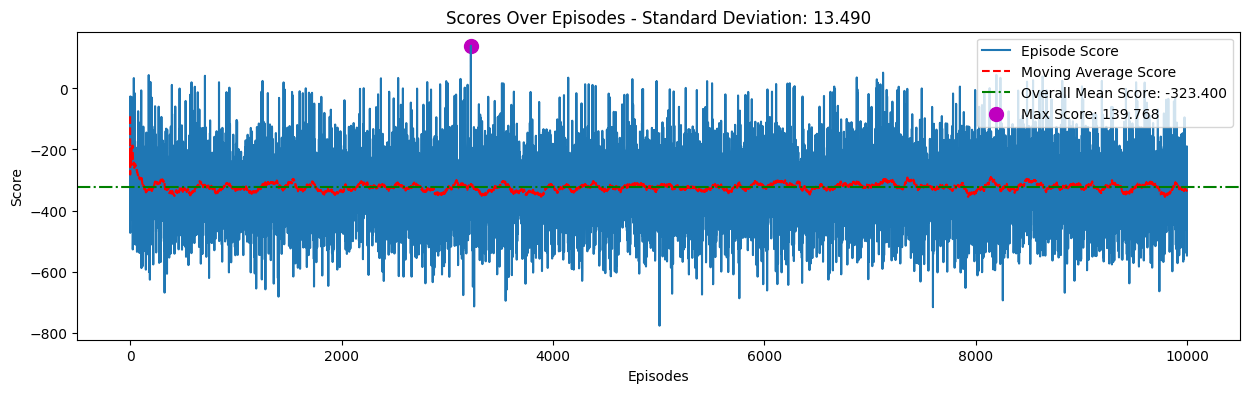

In [16]:
def main():
    env = gym.make('LunarLander-v2')
    num_actions = env.action_space.n
    state_dim = env.observation_space.shape[0]

    agent = Agent(num_actions, state_dim)
    TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
    Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

    training_records = []
    best_score = -np.inf  # 추가: 최고 점수를 추적하기 위한 변수

    episodes = 10000
    time_step = 300

    for i_ep in range(episodes):
        score = 0
        state = env.reset()[0]

        for t in range(time_step):
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            action_tensor = agent.select_action(state)

            # Convert action_tensor to NumPy array
            action = action_tensor.cpu().numpy()[0]

            state_, reward, done, TRUC, _ = env.step(action)
            score += reward
            agent.store_transition(Transition(state, action_tensor, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()

            if done:
                break

        training_records.append(TrainingRecord(i_ep, score))

        if i_ep % 10 == 0:
            avg_score = np.mean([r.reward for r in training_records[-100:]])
            print(f"Episode {i_ep + 1}, Score: {score:.3f}, Avg Score (last 100): {avg_score:.3f}")

        # 추가: 현재 보상이 최고 보상보다 큰 경우 모델 저장
        if score > best_score:
            best_score = score
            print("====Saving the best model====")
            print(f"--> Episode {i_ep + 1}, Score: {score:.3f}, Avg Score (last 100): {avg_score:.3f}")            
            torch.save(agent.eval_anet.state_dict(), 'best_model_DDPG_4_layer.pth')

    env.close()

    moving_avg_scores = [np.mean([r.reward for r in training_records[max(0, i-100):i]]) for i in range(1, len(training_records)+1)]
    plot_score([r.reward for r in training_records], moving_avg_scores, save_path='DDPG_4_layer.png')
    agent.save_scores_to_csv('scores_DDPG_4_layer.csv', range(1, i_ep + 2), [r.reward for r in training_records], moving_avg_scores)

if __name__ == '__main__':
    main()

In [ ]:
def plot_score_from_csv(csv_path, save_path=None):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Extract data
    episodes = df['Episode']
    scores = df['Score']
    moving_avg_scores = df['Avg_Score']

    # Plot the scores
    plt.figure(figsize=(15, 4))

    # Plot Episode Score
    plt.plot(episodes, scores, label='Episode Score')

    # Plot Moving Average Score
    plt.plot(episodes, moving_avg_scores, label='Moving Average Score', color='r', linestyle='--')

    # Plot Overall Mean Score
    overall_mean_score = np.mean(scores)
    plt.axhline(y=overall_mean_score, color='g', linestyle='-.', label=f'Overall Mean Score: {overall_mean_score:.2f}')

    # Find and Plot Maximum Score
    max_score = np.max(scores)
    plt.scatter(np.argmax(scores), max_score, color='m', label=f'Max Score: {max_score:.2f}', marker='o', s=100)

    # Plot Standard Deviation
    std_dev_score = np.std(moving_avg_scores)
    plt.title(f"Scores Over Episodes - Standard Deviation: {std_dev_score:.2f}")

    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()

    # Save the plot to an image file if save_path is provided
    if save_path:
        plt.savefig(save_path)

    # Show the plot (either in a window or saved file)
    plt.show()

# Example usage assuming your CSV file is named 'training_records_DDPG.csv'
plot_score_from_csv('scores_DDPG.csv', save_path='scores_DDPG.png')